In [4]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [26]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [27]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [28]:
# create engine to hawaii.sqlite
engine = create_engine(r"sqlite:///C:\Users\jrobe\Documents\Challenge 10\sqlalchemy-challenge\Resources\hawaii.sqlite")
engine
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\jrobe\AppData\Local\Temp\ipykernel_8112\2530713852.py:8: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [29]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [30]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [31]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [32]:
# Find the most recent date in the data set.
most_recent_date_str = session.query(func.max(Measurement.date)).scalar()
print(f"Most Recent Date: {most_recent_date_str}")

Most Recent Date: 2017-08-23


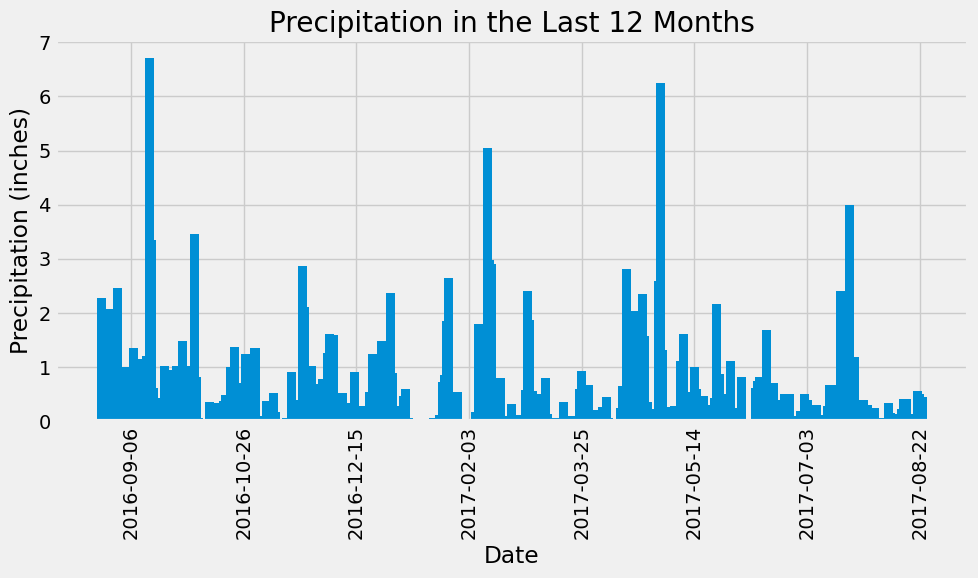

In [33]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database. 
most_recent_date = datetime.strptime(most_recent_date_str, '%Y-%m-%d')
one_year_ago = most_recent_date - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores for the last 12 months
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).all()

# Close the session
session.close()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the DataFrame by date
precipitation_df['Date'] = pd.to_datetime(precipitation_df['Date'])
precipitation_df.sort_values(by='Date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.bar(precipitation_df['Date'], precipitation_df['Precipitation'], width=4)
plt.title('Precipitation in the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Adjust the number of date labels
plt.tight_layout()
plt.show()

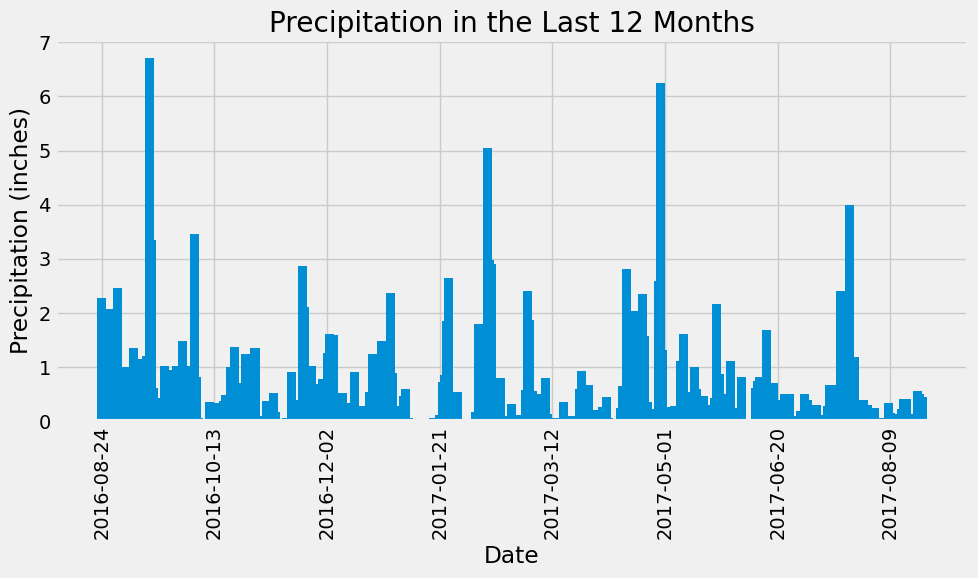

In [34]:
# Calculate the date one year from the last date in data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d')
one_year_ago = most_recent_date - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df.sort_values(by='Date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.bar(precipitation_df['Date'], precipitation_df['Precipitation'], width=4)
plt.title('Precipitation in the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Adjust the number of date labels
plt.tight_layout()
plt.show()

In [35]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = precipitation_df.describe()
summary_stats

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [36]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
total_stations

9

In [37]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

# List the stations and their counts in descending order.
print("Most Active Stations:")
for station, count in active_stations:
    print(f"Station {station}: {count} observations")

Most Active Stations:
Station USC00519281: 2772 observations
Station USC00519397: 2724 observations
Station USC00513117: 2709 observations
Station USC00519523: 2669 observations
Station USC00516128: 2612 observations
Station USC00514830: 2202 observations
Station USC00511918: 1979 observations
Station USC00517948: 1372 observations
Station USC00518838: 511 observations


In [38]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]
temp_data = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()

print(f"Temperature Analysis for Station {most_active_station}:")
print(f"Lowest Temperature Recorded: {temp_data[0][0]}°F")
print(f"Highest Temperature Recorded: {temp_data[0][1]}°F")
print(f"Average Temperature Recorded: {round(temp_data[0][2], 2)}°F")

Temperature Analysis for Station USC00519281:
Lowest Temperature Recorded: 54.0°F
Highest Temperature Recorded: 85.0°F
Average Temperature Recorded: 71.66°F


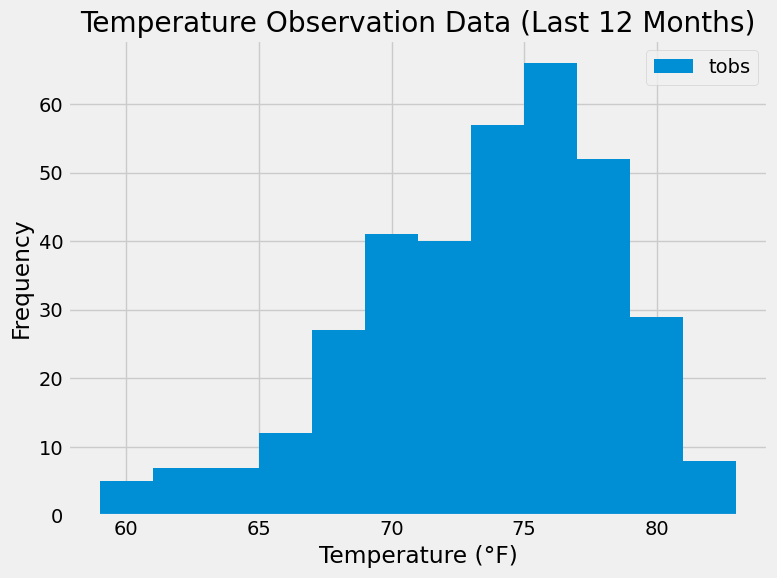

In [39]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= one_year_ago).\
    filter(Measurement.station == most_active_station).\
    order_by(Measurement.date).all()

temperature_df = pd.DataFrame(temperature_data, columns=['Date', 'Temperature'])

plt.figure(figsize=(8, 6))
plt.hist(temperature_df['Temperature'], bins=12)
plt.title('Temperature Observation Data (Last 12 Months)')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.legend(['tobs'])
plt.tight_layout()
plt.show()

# Close Session

In [40]:
# Close Session
session.close()